# Carga y análisis del dataset

Instalar librerías necesarias (si no están instaladas)

In [ ]:
!pip install pandas openpyxl matplotlib seaborn --quiet
!pip install datasets --quiet
!pip install numpy==1.26.4 --quiet # (versión anterior)

# Después de ejecutar estos comandos es necesario reiniciar el kernel

Importar librerías


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset
import torch

Carga del dataset y normalización

In [ ]:
ruta = "/content/Dataset_Completo.xlsx"
df = pd.read_excel(ruta)

# Limpieza y normalización de la columna 'Category'
df['Category'] = df['Category'].astype(str).str.strip().str.lower()

# Mapeo de etiquetas: 'true' → 0 y 'fake' → 1
df['label'] = df['Category'].map({'true': 0, 'fake': 1})

# Verificación
print("Valores únicos en 'Category':", df['Category'].unique())
print("Valores únicos en 'label':", df['label'].unique())
print("\nDistribución de clases:")
print(df['label'].value_counts())

Valores únicos en 'Category': ['fake' 'true']
Valores únicos en 'label': [1 0]

Distribución de clases:
label
0    777
1    766
Name: count, dtype: int64


Distribución de clases

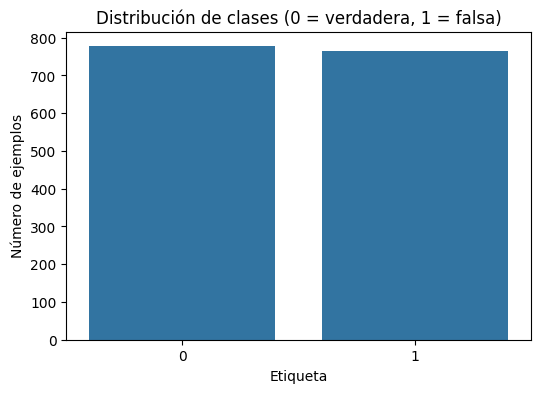

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title("Distribución de clases (0 = verdadera, 1 = falsa)")
plt.xlabel("Etiqueta")
plt.ylabel("Número de ejemplos")
plt.show()

Convertimos a texto y calculamos la longitud

In [ ]:
df['text_len'] = df['Text'].astype(str).apply(len)
print("\nLongitud media de los textos:", df['text_len'].mean())


Longitud media de los textos: 2662.167206740117


Gráfico distribución de la longitud de los textos

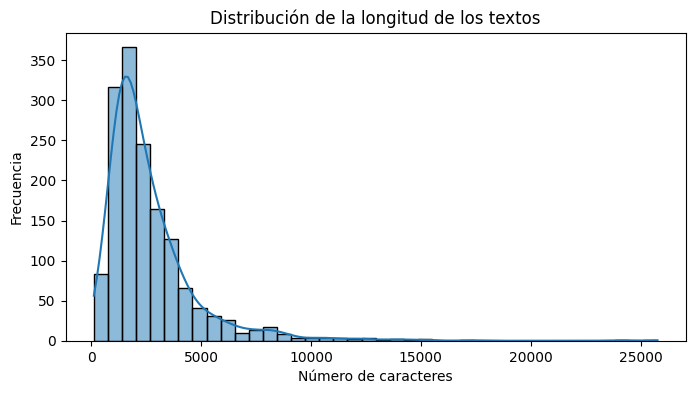

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['text_len'], bins=40, kde=True)
plt.title("Distribución de la longitud de los textos")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

Mostrar primeros registros del dataset

In [ ]:
# Mostrar los primeros registros del dataset
print("\nPrimeros registros del dataset:")
df.head()


Primeros registros del dataset:


,Id,Category,Topic,Source,Headline,Text,Link,label,text_len
0,1,fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...,1,2605
1,2,fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...,1,1063
2,3,fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...,1,2469
3,4,true,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...,0,1087
4,5,fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...,1,5404


Datos nulos y datos faltantes

In [ ]:
# Comprobar si existen registros con al menos un campo en blanco o nulo
registros_con_faltantes = df[df.isnull().any(axis=1)]
total_con_faltantes = registros_con_faltantes.shape[0]

# Mostrar resultado general
print(f"¿Existen registros con datos faltantes?: {total_con_faltantes > 0}")
print(f"Total de registros con al menos un campo en blanco: {total_con_faltantes}\n")

# Mostrar el número de valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

¿Existen registros con datos faltantes?: True
Total de registros con al menos un campo en blanco: 3

Valores nulos por columna:
Id          0
Category    0
Topic       0
Source      0
Headline    0
Text        0
Link        3
label       0
text_len    0
dtype: int64


In [ ]:
# Visualizar los primeros registros con campos faltantes
if total_con_faltantes > 0:
    print("\nPrimeros registros con campos faltantes:")
    print(registros_con_faltantes.head())


Primeros registros con campos faltantes:
        Id Category     Topic      Source  \
1090  1091     fake  Covid-19  AFPFactual   
1178  1179     fake  Covid-19    Facebook   
1210  1211     fake  Covid-19  AFPFactual   

                                               Headline  \
1090  Quienes estamos en la primera línea de campaña...   
1178  El Laboratorio Biológico Chino de Wuhan es en ...   
1210  ¡¡¡ATENCIÓN PERÚ!!! QUIENES VENDEN : LA IVERME...   

                                                   Text Link  label  text_len  
1090   #Atención "Quienes estamos en la primera líne...  NaN      1       339  
1178  El Laboratorio Biológico Chino de Wuhan es en ...  NaN      1       813  
1210  ¡¡¡ATENCIÓN PERÚ!!! QUIENES VENDEN : LA IVERME...  NaN      1       400  


# Entrenamiento de BETO con el texto completo


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Usamos 'text', 'topic', 'source' y 'headline' como entrada. El campo LINK no lo utilizamos para el entrenamiento
df_texto = df[['Text', 'Topic', 'Source', 'Headline', 'label']].dropna().copy()

# Renombramos todas las columnas
df_texto.rename(columns={
    'Text': 'text',
    'Topic': 'topic',
    'Source': 'source',
    'Headline': 'headline'
}, inplace=True)

# 2. División del dataset en entrenamiento y prueba
train_df, test_df = train_test_split(df_texto, test_size=0.2, stratify=df_texto['label'], random_state=42)

# 3. Conversión a datasets de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 4. Tokenizador y tokenización
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# 5. Formateo
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 6. Modelo BETO
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=2)

# 7. Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir="./results_texto_completo",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",  # Para evaluar cada época
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=10,
    report_to="none"
)

# 8 Preparación metricas entrenamiento
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# 9. Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Espera 2 épocas sin mejorar
)

# 10. Entrenar el modelo
trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

Map:   0%|          | 0/1234 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.402800,0.462706,0.828479
2,0.363700,0.364135,0.854369
3,0.203200,0.823986,0.831715
4,0.031900,0.843596,0.847896


TrainOutput(global_step=312, training_loss=0.2782386361848181, metrics={'train_runtime': 551.5842, 'train_samples_per_second': 22.372, 'train_steps_per_second': 1.414, 'total_flos': 1298716169256960.0, 'train_loss': 0.2782386361848181, 'epoch': 4.0})

Guardar el modelo entrenado con textos (lo usaremos con LIME).

In [ ]:
# Guardar modelo y tokenizer tras el entrenamiento
trainer.save_model("./modelo_beto_fake_news")
tokenizer.save_pretrained("./modelo_beto_fake_news")

('./modelo_beto_fake_news/tokenizer_config.json',
 './modelo_beto_fake_news/special_tokens_map.json',
 './modelo_beto_fake_news/vocab.txt',
 './modelo_beto_fake_news/added_tokens.json')

# Evaluación del modelo con texto completo

Accuracy: 0.8544
Precision: 0.9030
Recall: 0.7908
F1-score: 0.8432

Reporte completo:
              precision    recall  f1-score   support

        True       0.82      0.92      0.86       156
        Fake       0.90      0.79      0.84       153

    accuracy                           0.85       309
   macro avg       0.86      0.85      0.85       309
weighted avg       0.86      0.85      0.85       309



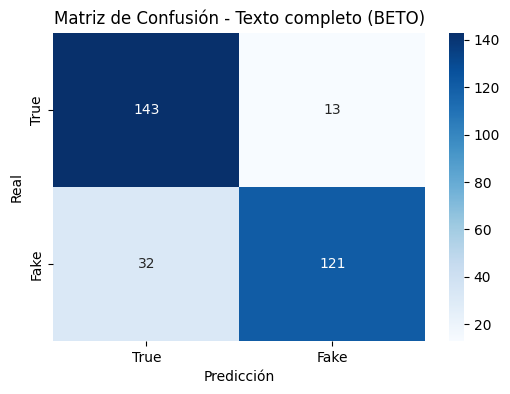

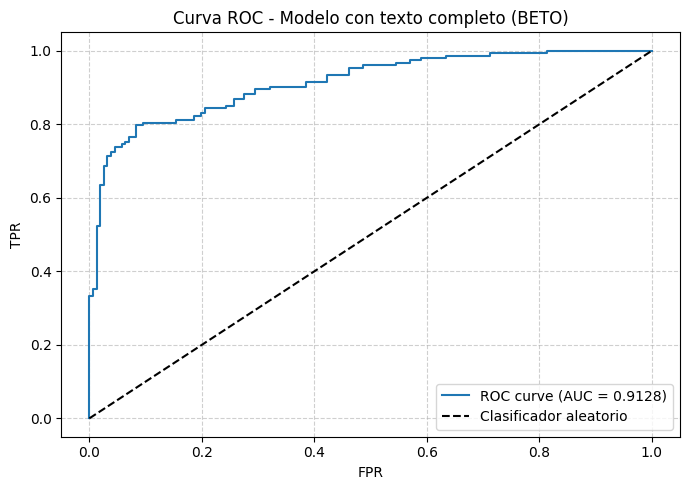

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# 1. Obtener predicciones
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 2. Métricas principales
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 3. Reporte completo por clase
print("\nReporte completo:")
print(classification_report(labels, preds, target_names=["True", "Fake"]))

# 4. Matriz de confusión
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["True", "Fake"], yticklabels=["True", "Fake"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Texto completo (BETO)')
plt.show()

# 5. Curva ROC y AUC
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
auc = roc_auc_score(labels, probs)
fpr, tpr, _ = roc_curve(labels, probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Modelo con texto completo (BETO)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



---



# Interpretabilidad con LIME

Instalar LIME

In [ ]:
!pip install lime --quiet

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="./modelo_beto_fake_news",
    tokenizer="./modelo_beto_fake_news",
    return_all_scores=True
)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Importaciones y función predictiva

In [ ]:
from lime.lime_text import LimeTextExplainer

# Definimos los nombres de las clases
class_names = ['True', 'Fake']

# Función para LIME: devuelve solo las probabilidades de clase
def predict_lime(texts):
    outputs = pipe(texts)
    return np.array([[s['score'] for s in o] for o in outputs])

Inicializar el explicador y elegir un texto

In [ ]:
explainer = LimeTextExplainer(class_names=class_names, random_state=42)

# Seleccionamos un texto del dataset
texto_ejemplo = df['Text'].dropna().astype(str).iloc[0][:1000]  # truncado por seguridad

Generar la explicación y visualizarla

In [ ]:
exp = explainer.explain_instance(texto_ejemplo, predict_lime, num_features=10)

# Mostrar en notebook
exp.show_in_notebook(text=True)

Guardar la explicación LIME como archivo HTML

In [ ]:
# Guardar la explicación como archivo HTML
exp.save_to_file('lime_explicacion_BETO.html')



---



# Interpretabilidad con SHAP

Aunque las explicaciones SHAP se generan sobre un modelo base multilingüe, la interpretación general puede extrapolarse razonablemente al comportamiento del modelo fine-tuned entrenado en este trabajo, ya que ambos comparten la misma arquitectura.

Instalar librerías necesarias

In [ ]:
!pip install shap scikit-learn nltk --quiet

Importaciones

In [ ]:
import shap
import torch
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Crear el masker y explainer
masker = shap.maskers.Text(tokenizer=pipe.tokenizer)
explainer = shap.Explainer(pipe, masker)

# Aseguramos textos, convertimos a string y limitamos a 1000 caracteres (preparamos los cinco primeros registros)
sample_texts_shap = df['Text'].dropna().astype(str).apply(lambda x: x[:1000]).tolist()[:5]

# Obtener explicaciones
shap_values = explainer(sample_texts_shap)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:52<00:12,  6.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:01<00:07,  7.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [01:08<00:00,  7.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [01:17, 15.40s/it]


In [ ]:
# Visualizar una explicación
shap.plots.text(shap_values[0], display=True)

Guardar la explicación SHAP como archivo HTML

In [ ]:
# Guardar como archivo HTML
html_explanation = shap.plots.text(shap_values[0], display=False)
with open("shap_explicacion_BETO.html", "w", encoding="utf-8") as f:f.write(html_explanation)

Gráfico de barras Tokens más influyentes (sin filtrar)

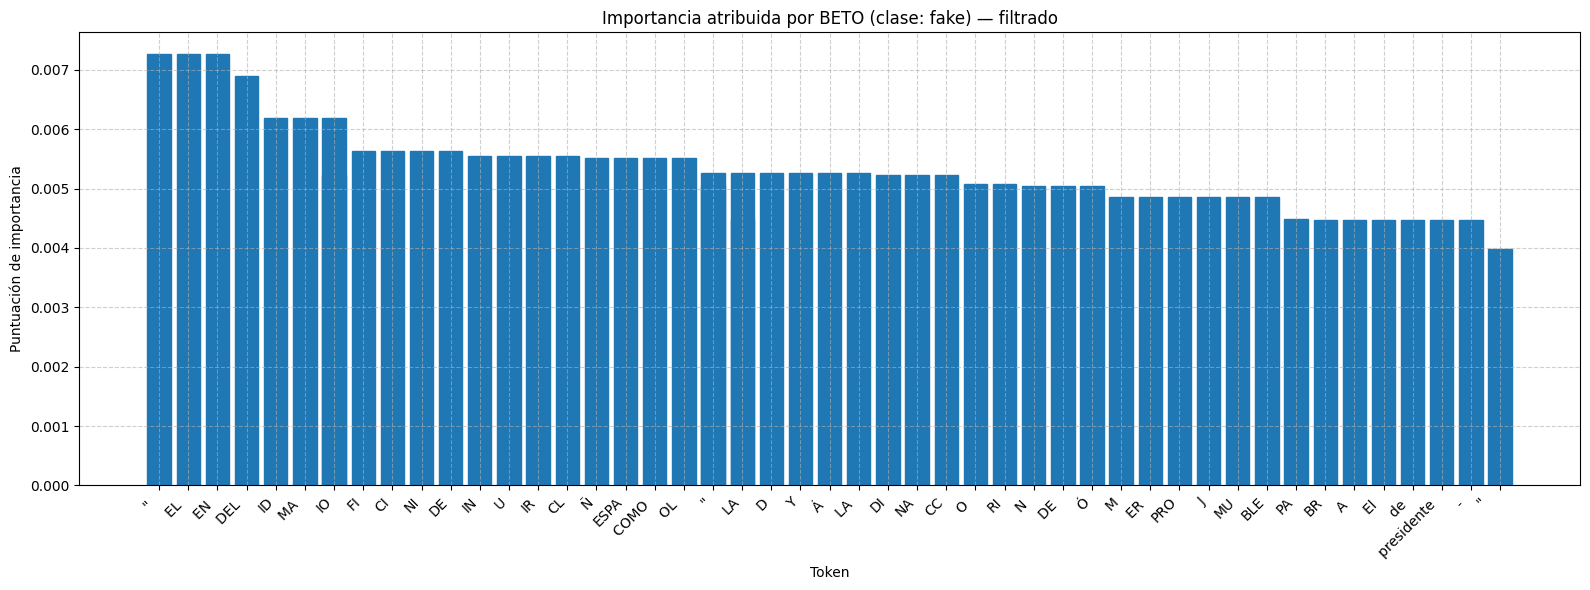

In [ ]:
# Obtener tokens y valores SHAP para la clase 1 ("fake")
tokens = shap_values[0].data
importancias = shap_values[0].values[:, 1]  # Tomamos la importancia para la clase 1

# Crear DataFrame
df_orden = pd.DataFrame({"Token": tokens, "SHAP": importancias})

# Seleccionar top 50 por magnitud del SHAP value
df_orden['SHAP_abs'] = df_orden['SHAP'].abs()
df_orden = df_orden.sort_values(by='SHAP_abs', ascending=False).head(50)

# Ordenar por magnitud absoluta (impacto)
df_orden["SHAP_abs"] = df_orden["SHAP"].abs()
df_ordenado = df_orden.sort_values(by="SHAP_abs", ascending=False)

# Seleccionar top 50 tokens más influyentes
top_n = 50
df_top = df_ordenado.head(top_n)

# Crear gráfico de barras
plt.figure(figsize=(16, 6))
bars = plt.bar(df_top["Token"], df_top["SHAP"], edgecolor='black')

# Colorear según signo
for bar, value in zip(bars, df_top["SHAP"]):
    bar.set_color('#1f77b4' if value > 0 else 'red')

plt.xticks(rotation=45, ha='right')
plt.title("Importancia atribuida por BETO (clase: fake) — filtrado")
plt.xlabel("Token")
plt.ylabel("Puntuación de importancia")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Gráfico de barras importancia FILTRADO

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


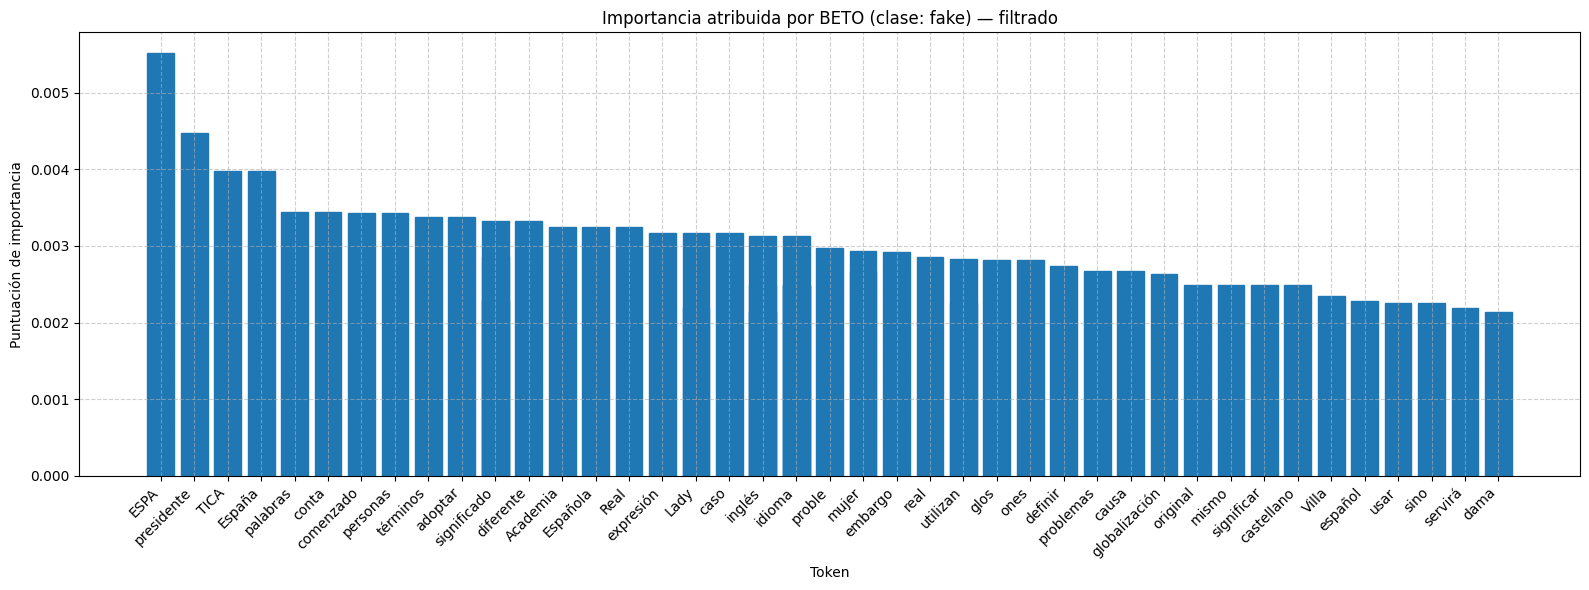

In [ ]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# Obtener tokens y valores SHAP para la clase 1 ("fake")
tokens = [t.strip() for t in shap_values[0].data]  # Limpieza: eliminar espacios extra
importancias = shap_values[0].values[:, 1]  # Importancia para clase 1

# Crear DataFrame
df = pd.DataFrame({
    "Token": tokens,
    "SHAP": importancias
})

# Filtrar:
df_filtrado = df[df["Token"].str.isalpha()]  # 1. Eliminar tokens que no son alfabéticos
df_filtrado = df_filtrado[~df_filtrado["Token"].str.lower().isin(spanish_stopwords)]  # 2. Eliminar stopwords
df_filtrado = df_filtrado[df_filtrado["Token"].str.len() >= 4]  # 3. Eliminar tokens con menos de 4 letras

# Ordenar por magnitud absoluta (impacto)
df_filtrado["SHAP_abs"] = df_filtrado["SHAP"].abs()
df_sorted = df_filtrado.sort_values(by="SHAP_abs", ascending=False)

# Seleccionar top 50 tokens más influyentes
top_n = 50
df_top = df_sorted.head(top_n)

# Crear gráfico de barras
plt.figure(figsize=(16, 6))
bars = plt.bar(df_top["Token"], df_top["SHAP"], edgecolor='black')

# Colorear según signo
for bar, value in zip(bars, df_top["SHAP"]):
    bar.set_color('#1f77b4' if value > 0 else 'red')

plt.xticks(rotation=45, ha='right')
plt.title("Importancia atribuida por BETO (clase: fake) — filtrado")
plt.xlabel("Token")
plt.ylabel("Puntuación de importancia")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Nube de palabras

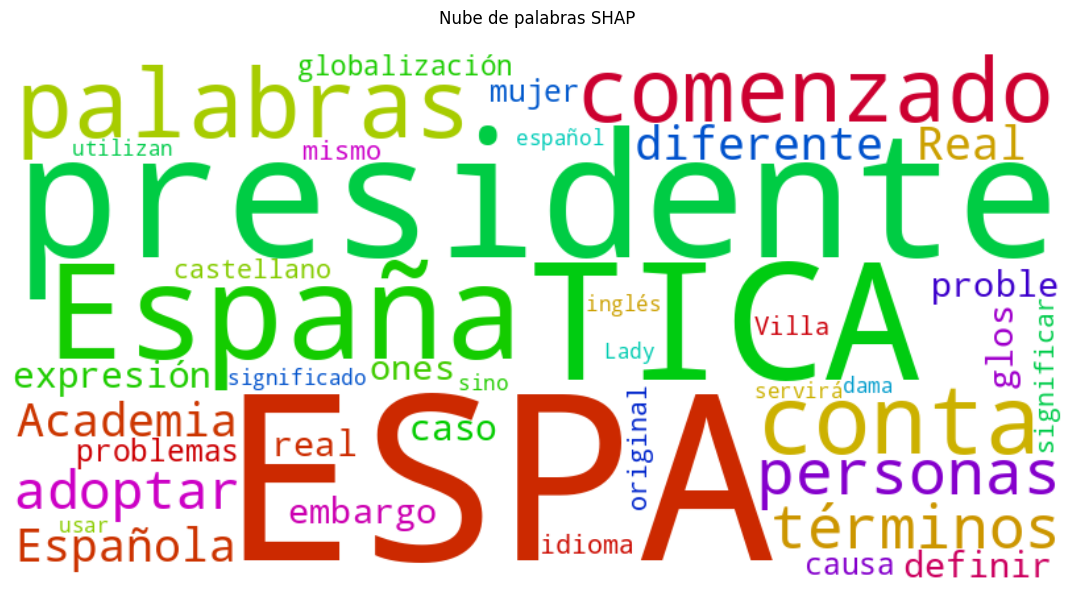

In [ ]:
from wordcloud import WordCloud

# Crear diccionario de frecuencias
frequencies = dict(zip(df_top["Token"], df_top["SHAP_abs"]))

import random
random.seed(42)

# Función de color aleatorio
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl({}, 100%, 40%)".format(random.randint(0, 360))

# Crear y generar la nube
wc = WordCloud(width=800, height=400, background_color='white', color_func=random_color_func)
wc.generate_from_frequencies(frequencies)

# Mostrar nube
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras SHAP\n")
plt.tight_layout()
plt.show()

Tokens más influyentes FILTRADO (con valores exactos)

In [ ]:
def analizar_shap_explicacion2(shap_value, top_n=5, filtrar=True, class_index=None):

    # 1. Qué clase usar
    base_values = shap_value.base_values
    class_index = 1

    base_value = base_values[class_index] if isinstance(base_values, np.ndarray) else base_values

    # 2. Extraer valores SHAP de la clase activa
    shap_vals = shap_value.values
    if isinstance(shap_vals[0], np.ndarray):
        shap_vals = [v[class_index] for v in shap_vals]

    tokens = [t.strip() for t in shap_value.data]  # Eliminamos espacios extra
    total_contrib = np.sum(shap_vals)
    fx = base_value + total_contrib

    print("Análisis de predicción individual")
    print(f"Clase analizada: {class_index}")
    print(f"Valor base del modelo: {base_value:.3f}")
    print(f"Suma total de contribuciones (tokens): {total_contrib:.3f}")
    print(f"Predicción final (f(x)) ≈ {fx:.3f}")

    # 3. Crear DataFrame de tokens
    df = pd.DataFrame({
        "Token": tokens,
        "SHAP": shap_vals
    })

    # 4. Filtro
    if filtrar:
        df["Token"] = df["Token"].str.strip()  # limpieza adicional por seguridad
        df = df[df["Token"].str.isalpha()]  # Elimina puntuación y símbolos
        df = df[~df["Token"].str.lower().isin(spanish_stopwords)]  # Elimina stopwords
        df = df[df["Token"].str.len() >= 4]  # Elimina tokens muy cortos

    # 5. Ordenar por impacto absoluto
    df["SHAP_abs"] = df["SHAP"].abs()
    df_sorted = df.sort_values(by="SHAP_abs", ascending=False)

    # 6. Mostrar top_n tokens más influyentes
    top_tokens = df_sorted.head(top_n)

    print("\n Tokens más influyentes (positivo o negativo):")
    print(top_tokens[["Token", "SHAP"]].to_string(index=False))

    # 7. Conclusión
    if fx > 0.5:
        conclusion = "El modelo cree que esta noticia es FALSA (LABEL_1)."
    elif fx < 0.5:
        conclusion = "El modelo cree que esta noticia es VERDADERA (LABEL_0)."
    else:
        conclusion = "El modelo está indeciso entre FALSA y VERDADERA."

    print(f"\nConclusión del modelo: {conclusion}")

In [ ]:
analizar_shap_explicacion2(shap_values[0], top_n=10, filtrar=True, class_index=0)

Análisis de predicción individual
Clase analizada: 1
Valor base del modelo: 0.279
Suma total de contribuciones (tokens): 0.717
Predicción final (f(x)) ≈ 0.996

 Tokens más influyentes (positivo o negativo):
     Token     SHAP
      ESPA 0.005509
presidente 0.004467
      TICA 0.003983
    España 0.003983
  palabras 0.003443
     conta 0.003443
 comenzado 0.003427
  personas 0.003427
  términos 0.003372
   adoptar 0.003372

Conclusión del modelo: El modelo cree que esta noticia es FALSA (LABEL_1).


Análisis de predicción individual (tokens que empujan hacia cada clase)

In [ ]:
def analizar_shap_explicacion(shap_value, top_n=5, filtrar=True):

    # 1. Qué clase usar
    base_values = shap_value.base_values
    class_index = 1

    base_value = base_values[class_index] if isinstance(base_values, np.ndarray) else base_values

    # 2. Extraer valores SHAP de la clase activa
    shap_vals = shap_value.values
    if isinstance(shap_vals[0], np.ndarray):
        shap_vals = [v[class_index] for v in shap_vals]

    tokens = [t.strip() for t in shap_value.data]  # Eliminamos espacios extra
    total_contrib = np.sum(shap_vals)
    fx = base_value + total_contrib

    print("Análisis de predicción individual")
    print(f"Clase analizada: {class_index}")
    print(f"Valor base del modelo: {base_value:.3f}")
    print(f"Suma total de contribuciones (tokens): {total_contrib:.3f}")
    print(f"Predicción final (f(x)) ≈ {fx:.3f}")

    # 3. Crear DataFrame de tokens
    df = pd.DataFrame({
        "Token": tokens,
        "SHAP": shap_vals
    })

    # 4. Filtro
    if filtrar:
        df["Token"] = df["Token"].str.strip()  # limpieza adicional por seguridad
        df = df[df["Token"].str.isalpha()]  # Elimina puntuación y símbolos
        df = df[~df["Token"].str.lower().isin(spanish_stopwords)]  # Elimina stopwords
        df = df[df["Token"].str.len() >= 4]  # Elimina tokens muy cortos


    # 5. Tokens más influyentes
    top_neg = df.sort_values(by="SHAP").head(top_n)
    top_pos = df.sort_values(by="SHAP", ascending=False).head(top_n)

    print("\n🔻 Tokens que empujan hacia la clase contraria:")
    print(top_neg.to_string(index=False))

    print("\n🔺 Tokens que empujan hacia esta clase:")
    print(top_pos.to_string(index=False))

    # 6. Resultado
    if fx > 0.5:
        conclusion = "El modelo cree que esta noticia es FALSA (LABEL_1)."
    elif fx < 0.5:
        conclusion = "El modelo cree que esta noticia es VERDADERA (LABEL_0)."
    else:
        conclusion = "El modelo está indeciso entre FALSA y VERDADERA."

    print(f"\nConclusión del modelo: {conclusion}")

In [ ]:
analizar_shap_explicacion(shap_values[0])

Análisis de predicción individual
Clase analizada: 1
Valor base del modelo: 0.279
Suma total de contribuciones (tokens): 0.717
Predicción final (f(x)) ≈ 0.996

🔻 Tokens que empujan hacia la clase contraria:
      Token     SHAP
diccionario 0.000272
    español 0.000272
     idioma 0.000272
    informó 0.000491
     prensa 0.000491

🔺 Tokens que empujan hacia esta clase:
     Token     SHAP
      ESPA 0.005509
presidente 0.004467
      TICA 0.003983
    España 0.003983
  palabras 0.003443

Conclusión del modelo: El modelo cree que esta noticia es FALSA (LABEL_1).




---


Tokens más influyentes: análisis global (sobre 100 registros aleatorios)

In [ ]:
# Usamos el dataset original con los textos
textos = df_texto['text'].dropna().astype(str).apply(lambda x: x[:1000]).tolist()

# Seleccionamos una muestra aleatoria
sample_texts = random.sample(textos, 100)

# Creamos el masker y el explainer si aún no están
masker = shap.maskers.Text(tokenizer=pipe.tokenizer)
explainer = shap.Explainer(pipe, masker)

# Aplicamos SHAP
shap_values = explainer(sample_texts)

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [00:27<07:52,  4.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [00:36<10:36,  6.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [00:44<11:24,  7.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [00:51<11:08,  7.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [00:59<11:33,  7.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [01:08<11:49,  7.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [01:16<11:51,  7.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [01:24<11:55,  8.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [01:33<11:59,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [01:41<12:04,  8.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [01:48<11:04,  7.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [01:56<11:08,  7.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [02:04<11:13,  8.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [02:13<11:23,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [02:21<11:14,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [02:32<12:17,  9.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [02:40<11:43,  8.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [02:49<11:22,  8.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [02:57<11:00,  8.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [03:05<10:52,  8.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [03:13<10:39,  8.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [03:19<09:21,  7.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [03:27<09:35,  7.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [03:36<09:42,  7.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [03:44<09:44,  8.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [03:52<09:39,  8.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [04:00<09:29,  8.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [04:09<09:29,  8.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [04:18<09:30,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [04:26<09:17,  8.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [04:34<09:14,  8.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [04:43<09:12,  8.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [04:49<08:06,  7.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [04:57<08:13,  7.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [05:06<08:19,  8.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [05:14<08:16,  8.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [05:22<08:13,  8.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [05:31<08:07,  8.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [05:39<07:57,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [05:47<07:52,  8.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [05:56<07:45,  8.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [06:04<07:32,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [06:12<07:28,  8.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [06:20<07:19,  8.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [06:28<07:08,  8.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [06:37<07:03,  8.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [06:45<06:57,  8.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [06:54<06:46,  8.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [07:02<06:41,  8.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [07:10<06:32,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [07:19<06:21,  8.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [07:27<06:15,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [07:35<06:08,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [07:44<06:00,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [07:52<05:51,  8.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [08:04<06:31,  9.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [08:13<06:07,  9.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [08:21<05:46,  8.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [08:30<05:39,  8.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [08:37<05:12,  8.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [08:46<05:00,  8.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [08:56<05:12,  8.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [09:04<05:00,  8.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [09:13<04:45,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [09:21<04:34,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [09:30<04:26,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [09:38<04:13,  8.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [09:45<03:53,  8.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [09:54<03:49,  8.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [10:02<03:40,  8.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [10:10<03:34,  8.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [10:20<03:40,  8.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [10:28<03:27,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [10:37<03:18,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [10:45<03:07,  8.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [10:53<02:56,  8.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [11:02<02:47,  8.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [11:10<02:39,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [11:27<03:14, 10.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [11:35<02:51, 10.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [11:43<02:33,  9.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [11:51<02:17,  9.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [12:00<02:04,  8.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [12:08<01:52,  8.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [12:16<01:42,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [12:23<01:29,  8.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [12:32<01:21,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [12:40<01:14,  8.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [12:49<01:06,  8.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [12:57<00:58,  8.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [13:05<00:49,  8.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [13:12<00:39,  7.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [13:20<00:31,  7.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [13:29<00:24,  8.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [13:37<00:16,  8.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [13:45<00:08,  8.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [13:54<00:00,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [14:03,  8.52s/it]


Mostrar los tokens más influyentes en gráfico de barras

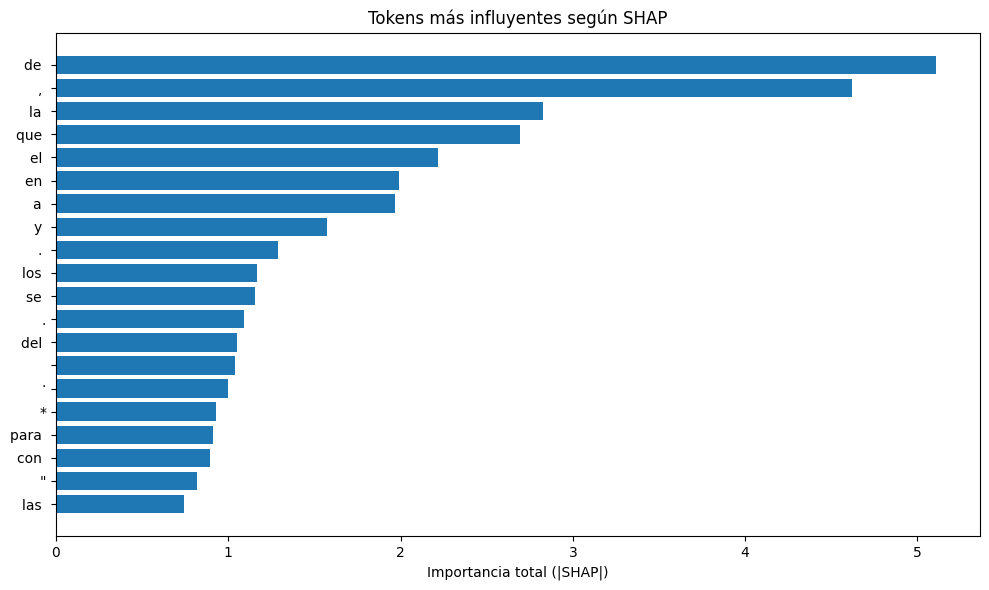

In [ ]:
import collections

# Acumulamos la contribución absoluta de cada token
token_contributions = collections.Counter()

for sv in shap_values:
    for token, value in zip(sv.data, sv.values):
        token_contributions[str(token)] += sum(abs(v) for v in value)

# Extraemos los 20 tokens más influyentes
top_tokens = token_contributions.most_common(20)

# Preparamos el gráfico
tokens, values = zip(*top_tokens)
plt.figure(figsize=(10, 6))
plt.barh(tokens[::-1], values[::-1])  # De menor a mayor
plt.xlabel("Importancia total (|SHAP|)")
plt.title("Tokens más influyentes según SHAP")
plt.tight_layout()
plt.show()

Eliminar stopwords en español

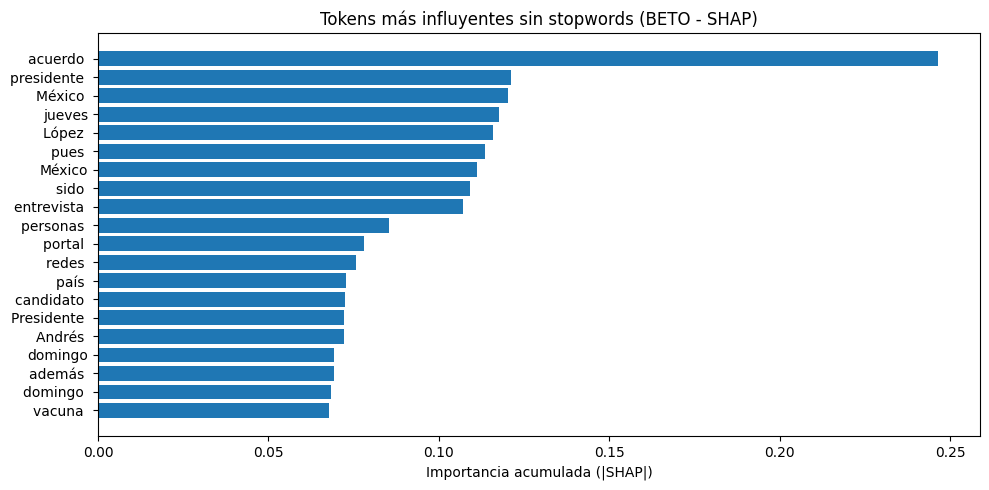

In [ ]:
import re

def limpiar_token(token):
    # Elimina todo lo que no sea letra (incluso espacios y signos) y pone en minúsculas
    return re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ]', '', token.lower().strip())


# Calcular contribuciones acumuladas
token_contributions = collections.Counter()
for sv in shap_values:
    for token, value in zip(sv.data, sv.values):
        token_contributions[str(token)] += sum(abs(v) for v in value)

# Filtrar: sin stopwords, sin símbolos, mínimo 4 letras
token_contributions_filtered = {
    token: score for token, score in token_contributions.items()
    if limpiar_token(token) not in spanish_stopwords and limpiar_token(token).isalpha() and len(limpiar_token(token)) >= 4
}

# Obtener los 20 tokens más influyentes
top_tokens = sorted(token_contributions_filtered.items(), key=lambda x: x[1], reverse=True)[:20]
tokens, scores = zip(*top_tokens)

# Mostrar gráfico
plt.figure(figsize=(10, 5))
plt.barh(tokens[::-1], scores[::-1])
plt.title("Tokens más influyentes sin stopwords (BETO - SHAP)")
plt.xlabel("Importancia acumulada (|SHAP|)")
plt.tight_layout()
plt.show()

Nube de palabras

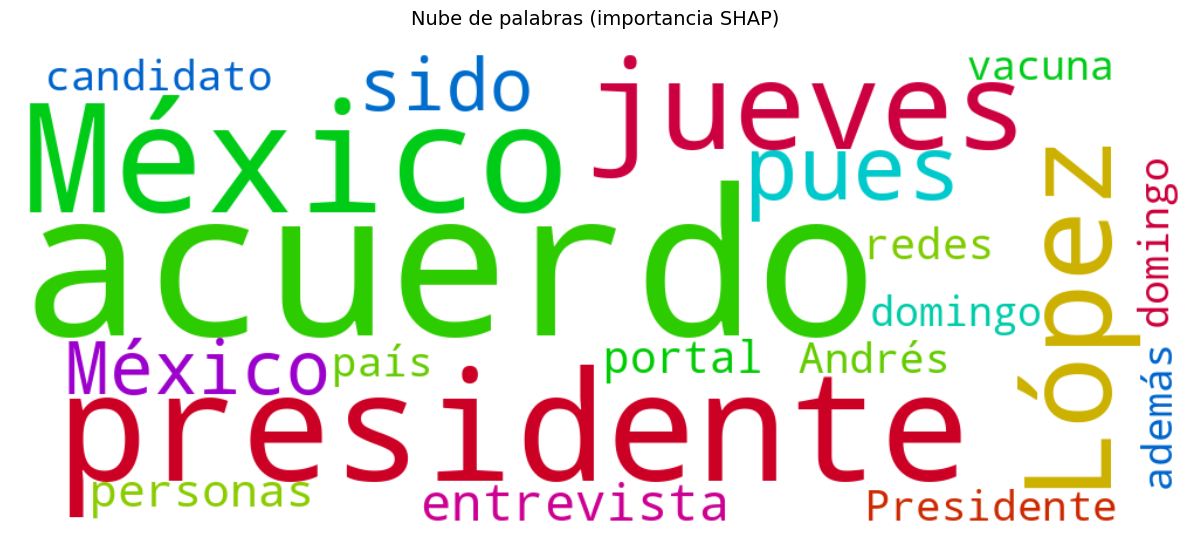

In [ ]:
# Seleccionar top 20 tokens más influyentes
top_n = 20
top_tokens = sorted(token_contributions_filtered.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Crear diccionario {token: valor absoluto de SHAP}
word_weights = {token: score for token, score in top_tokens}

# Función de color aleatorio en escala HSL
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl({}, 100%, 40%)".format(random.randint(0, 360))

# Crear y generar la nube de palabras
wc = WordCloud(
    width=1000,
    height=400,
    background_color='white',
    color_func=random_color_func,
    max_words=top_n
)

wc.generate_from_frequencies(word_weights)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras (importancia SHAP)\n", fontsize=14)
plt.tight_layout()
plt.show()

Gráficos por clase (tokens que empujan hacia Fake y tokens que empujan hacia True)

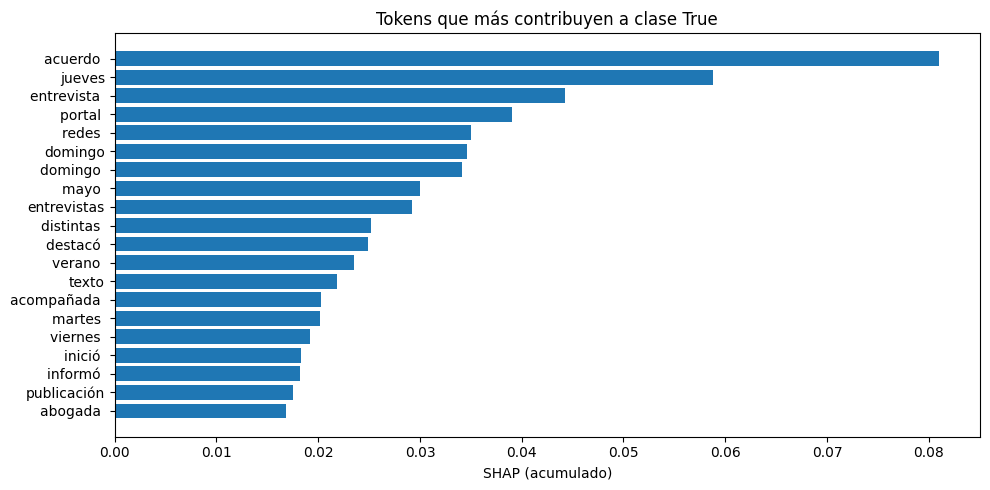

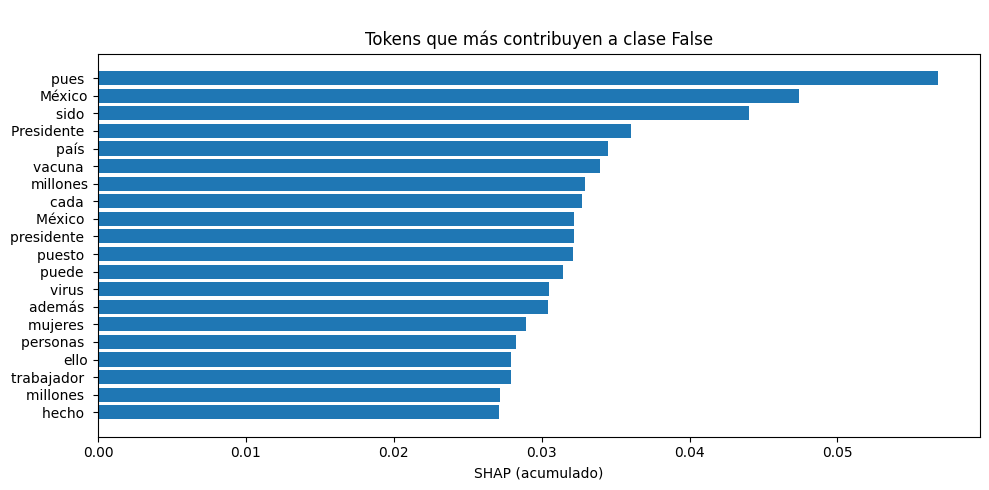

In [ ]:
# Contador para contribuciones hacia clase True (0) y clase False (1)
contrib_true = collections.Counter()
contrib_false = collections.Counter()

for sv in shap_values:
    for token, value in zip(sv.data, sv.values):
        contrib_true[str(token)] += value[0]   # Clase True
        contrib_false[str(token)] += value[1]  # Clase False

# Limpieza de tokens
contrib_true_cleaned = {
    token: score for token, score in contrib_true.items()
    if limpiar_token(token) not in spanish_stopwords and limpiar_token(token).isalpha() and len(limpiar_token(token)) >= 4
}

contrib_false_cleaned = {
    token: score for token, score in contrib_false.items()
    if limpiar_token(token) not in spanish_stopwords and limpiar_token(token).isalpha() and len(limpiar_token(token)) >= 4
}

# Mostrar tokens que más empujan hacia clase True
top_true = sorted(contrib_true_cleaned.items(), key=lambda x: x[1], reverse=True)[:20]
tokens_true, scores_true = zip(*top_true)

plt.figure(figsize=(10, 5))
plt.barh(tokens_true[::-1], scores_true[::-1])
plt.title("Tokens que más contribuyen a clase True")
plt.xlabel("SHAP (acumulado)")
plt.tight_layout()
plt.show()

# Mostrar tokens que más empujan hacia clase False
top_false = sorted(contrib_false_cleaned.items(), key=lambda x: x[1], reverse=True)[:20]
tokens_false, scores_false = zip(*top_false)

plt.figure(figsize=(10, 5))
plt.barh(tokens_false[::-1], scores_false[::-1])
plt.title("\nTokens que más contribuyen a clase False")
plt.xlabel("SHAP (acumulado)")
plt.tight_layout()
plt.show()

Nube de palabras bicolor (azul clase 0 - rojo clase 1)

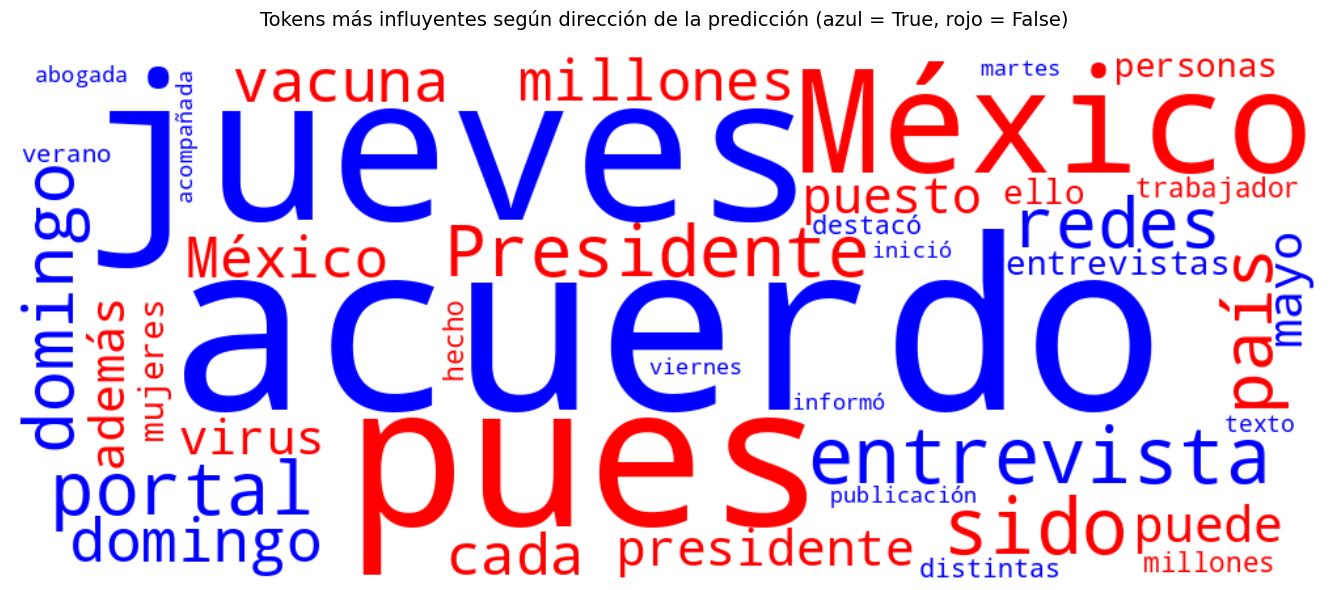

In [ ]:
# Construir diccionario combinado para la nube (valores absolutos)
word_freqs = {}

for token, score in top_true:
    word_freqs[token] = abs(score)

for token, score in top_false:
    word_freqs[token] = abs(score)

# Crear diccionario de colores: azul para True, rojo para False
def color_func(word, *args, **kwargs):
    if word in dict(top_true):
        return "blue"
    elif word in dict(top_false):
        return "red"
    else:
        return "gray"  # fallback por si acaso

# Generar nube de palabras
wc = WordCloud(
    width=1000,
    height=400,
    background_color='white',
    color_func=color_func
)

wc.generate_from_frequencies(word_freqs)

# Mostrar nube
plt.figure(figsize=(16, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Tokens más influyentes según dirección de la predicción (azul = True, rojo = False)\n", fontsize=14)
plt.tight_layout()
plt.show()



---



# Predicción manual con noticia nueva


In [ ]:
# === PREDICCIÓN MANUAL CON NOTICIA NUEVA ===


# Cargar modelo entrenado desde carpeta local
model_path = "./modelo_beto_fake_news"
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = BertForSequenceClassification.from_pretrained(model_path)

# Pasar a modo evaluación
model.eval()

# Noticia de prueba
text = "Una nueva ley establece que todos los coches deberán ser eléctricos en 2035."

# Tokenizar
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Predicción
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()

# Interpretar resultado
etiquetas = ["Real", "Fake"]  # Adjusted labels to match expected output
print("Predicción:", etiquetas[predicted_class_id]) # Adjusted labels to match expected output

Predicción: Fake


# También se puede hacer predicción manual iterando sobre los ejemplos uno a uno

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm  # Para barra de progreso

# Nos aseguramos de que el modelo y tokenizer están cargados
model.eval()

# Listas para almacenar predicciones y etiquetas reales
y_true = []
y_pred = []

for text, label in tqdm(zip(test_df["text"], test_df["label"]), total=len(test_df)):
    # Tokenizar
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()

    y_true.append(label)
    y_pred.append(pred_id)

# === Resultados ===
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred, average="weighted"))
print("\nReporte completo:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

100%|██████████| 309/309 [06:48<00:00,  1.32s/it]

Accuracy: 0.8349514563106796
F1-score: 0.834483144922173

Reporte completo:
               precision    recall  f1-score   support

        Fake       0.81      0.88      0.84       156
        Real       0.87      0.78      0.82       153

    accuracy                           0.83       309
   macro avg       0.84      0.83      0.83       309
weighted avg       0.84      0.83      0.83       309





---



# Código para la interfaz interactiva

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import gradio as gr


# Asegúrate de que el modelo y tokenizer están cargados
model.eval()
etiquetas = ["Real", "Fake"]

def clasificar_noticia(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()
    return f"Predicción: {etiquetas[pred_id]}"

# Interfaz con Gradio
demo = gr.Interface(
    fn=clasificar_noticia,
    inputs=gr.Textbox(lines=6, placeholder="Escribe o pega aquí una noticia..."),
    outputs="text",
    title="Detector de Noticias Fake con BETO",
    description="Introduce una noticia y el modelo clasificará si es FAKE o REAL."
)

# Lanza la app
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://faf1e13fbb5f13c7b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
